In [1]:
import pydicom
import numpy as np
from skimage.transform import resize,rescale
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import os
import pandas as pd

# hough ellipse transform
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse, resize
from skimage.draw import ellipse_perimeter
from skimage.color import gray2rgb
import skimage.io as io

# inmediate data process
from utils import normalize, get_rois, plot_axis, read_data
from utils import read_rois_and_axis_data

# segmentation
from segmentation_model import unet_model

# detection
from detection_model import Net, num_classes
from detection_machine import Detection

# registration
from registration_machine import Semi_auto_registration

# hyperparameters
from utils import input_size, img_height, img_width

# Detection Part

In [2]:
root_path = 'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_brut'
ims_T1sag, ims_T1, ims_T2sag, ims_T2, ims_T2star, pos,_,_,_ = read_data(root_path, if_normalized=True)

In [3]:
inds = []
infos = [
    ('Brebis 7', 'J-7'),
    ('Brebis 8', 'J-7'),
    ('Brebis 9', 'J-7'),
]

for j,info in enumerate(infos):
    for i,p in enumerate(pos):
        is_find = False
        if p.find(info[0]) is not -1 and p.find(info[1]) is not -1:
            inds.append(i)
            is_find = True
            break
    if is_find is False:
        print(infos[j], 'not found!')  

In [4]:
# detection part
net = Net(num_classes)
net.load_weights(filepath="./detection_model_weights/save_model_weights_36x36.ckpt")

ims = ims_T1sag[inds]

chosen_rate = 1 - 1e-1
detection_machine = Detection(net, ims, input_size)
detection_machine.operate(chosen_rate)

OPERATING
time consuming:  0:00:22.675370


In [5]:
dir_rois = r'.\intermediate_results'
rois_ens = detection_machine.read_and_save_rois(dir_rois)
rois_axis_ens = detection_machine.read_and_save_rois_axis(dir_rois)

READING AND SAVING ROI
Rois figures saved to .\intermediate_results successfully
READING AND SAVING ROI AXIS
Rois axis npy file saved to .\intermediate_results successfully


In [6]:
inds

[58, 63, 68]

The inds will be used afterwards in the segmentation parts

# Segmentation Part

In [7]:
# read rois imgs and rois_axis_ens from the detextion result
dir_rois = r'.\intermediate_results'
rois_ens, rois_axis_ens = read_rois_and_axis_data(dir_rois)

# 对于 rois data 的 pre process
copy = rois_ens.copy()
for i,rois in enumerate(copy): 
    rois = resize(rois.transpose(1,2,0), (img_height, img_width)).transpose(2,0,1)  
    rois = normalize(rois)        # 先normalization变成0到1
    rois = rois[:,:,:,np.newaxis]
    rois_ens[i] = rois
print(rois_ens[0].shape, rois_ens[0].dtype)

# 对于 axis 的 pre process
copy = rois_axis_ens.copy()
for i,rois_axis in enumerate(copy): 
    rois_axis[:,[1,0]] = rois_axis[:,[0,1]]  # 交换一下x和y的位置
    rois_axis = np.concatenate((rois_axis, np.array(input_size)[:,np.newaxis].repeat(rois_axis.shape[0], axis=1).T), axis=1)
    rois_axis_ens[i] = rois_axis
print(rois_axis_ens[0].shape, rois_axis_ens[0].dtype)

(7, 128, 128, 1) float32
(7, 4) int64


In [8]:
# segmentation models loading
input_shape = (img_height, img_width)

## mid
modified_input_size = (img_height, img_width,1)
model1 = unet_model(input_size = modified_input_size)
model1.load_weights("./segmentation_model_weights/weights_unet1.hdf5")

## both sides
model2 = unet_model(input_size = modified_input_size)
model2.load_weights("./segmentation_model_weights/weights_unet2.hdf5")

In [9]:
Y1_pred = []
Y2_pred = []
for rois, rois_axis in zip(rois_ens, rois_axis_ens):
    y1_pred = model1.predict(rois).squeeze()
    y2_pred = model2.predict(rois).squeeze()
    
    y1_pred = resize(y1_pred.transpose(1,2,0), input_size).transpose(2,0,1)  
    y2_pred = resize(y2_pred.transpose(1,2,0), input_size).transpose(2,0,1) 
    
    Y1_pred.append(y1_pred)
    Y2_pred.append(y2_pred)
print(Y1_pred[0].shape)
print(Y2_pred[0].shape)

(7, 36, 36)
(7, 36, 36)


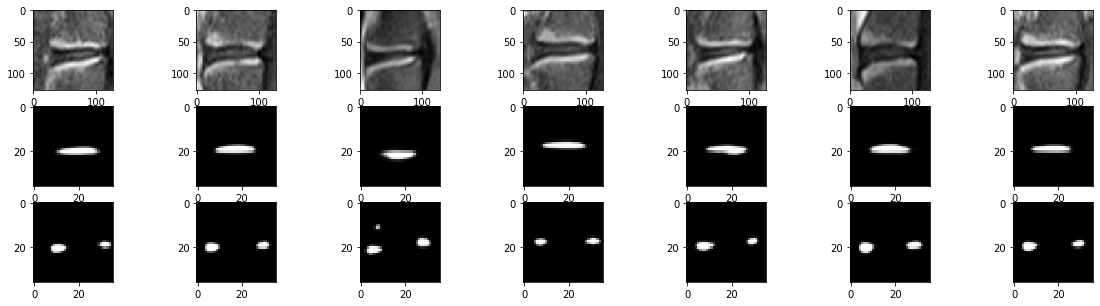

In [174]:
# show the first exemple 
N = Y1_pred[0].shape[0]
plt.figure(figsize=(20,5))
for i in range(N):
    plt.subplot(3,N,i+1)
    plt.imshow(rois_ens[0][i].squeeze(), cmap = 'gray')
    
    plt.subplot(3,N,i+N+1)
    plt.imshow(Y1_pred[0][i],cmap = 'gray')
    
    plt.subplot(3,N,i+2*N+1)
    plt.imshow(Y2_pred[0][i],cmap = 'gray')
plt.show()

# Registration Part

In [243]:
class Semi_auto_registration():
    def __init__(self, Y1_pred, Y2_pred, src_rois_axis_ens, src_input_size, 
                 ims_T1, ims_T2, ims_T2star, axis_ens_T1, axis_ens_T2, axis_ens_T2stare):
        self.Y1_pred = Y1_pred
        self.Y2_pred = Y2_pred
        self.ims_T1 = ims_T1
        self.ims_T2 = ims_T2
        self.ims_T2star = ims_T2star
        self.axis_ens_T1 = axis_ens_T1
        self.axis_ens_T2 = axis_ens_T2
        self.axis_ens_T2star = axis_ens_T2star
        self.src_size = (512,512)
        self.src_roi_size = Y1_pred[0].shape[1:]
        self.src_input_size = src_input_size
        self.src_rois_axis_ens = src_rois_axis_ens.copy()
        
    def get_rois(self, type_im):
        if type_im == 'T1':
            ims = self.ims_T1
            tgt_axis_ens = self.axis_ens_T1
        elif type_im == 'T2':
            ims = self.ims_T2
            tgt_axis_ens = self.axis_ens_T2  
        elif type_im == 'T2star':
            ims = self.ims_T2
            tgt_axis_ens = self.axis_ens_T2
        else:
            print('wrong type(should be T1, T2 or T2star)')
            return
        
        rois_ens = []
        Y1_pred_ens = []
        Y2_pred_ens = []
        for i, (im, tgt_axis) in enumerate(zip(ims, tgt_axis_ens)):
            y1_pred = self.Y1_pred[i].copy()
            y2_pred = self.Y2_pred[i].copy()
            
            # 注意下面src何tgt都有按照y轴从上到下排序的过程
            # registration of mask
            tgt_size = im.shape
            tgt_roi_size = (int(tgt_size[0]/self.src_size[0]*self.src_roi_size[0]), int(tgt_size[1]/self.src_size[1]*self.src_roi_size[1]))
            y1_pred = resize(y1_pred.transpose(1,2,0), tgt_roi_size).transpose(2,0,1) 
            y2_pred = resize(y2_pred.transpose(1,2,0), tgt_roi_size).transpose(2,0,1) 
            
            order = np.argsort(self.src_rois_axis_ens[i][:,1])
            y1_pred = y1_pred[order]
            y2_pred = y2_pred[order]
            
            # read rois
            rois, tgt_axis = self.get_rois_from_points_axis(im, tgt_axis, tgt_roi_size)
            order = np.argsort(tgt_axis[:,1])
            rois = rois[order]
            
            while len(rois) < len(y1_pred):
                y1_pred = np.delete(y1_pred, obj = 0, axis = 0)
                y2_pred = np.delete(y2_pred, obj = 0, axis = 0)
                
            rois_ens.append(rois)
            Y1_pred_ens.append(y1_pred)
            Y2_pred_ens.append(y2_pred)
            
        return rois_ens, Y1_pred_ens, Y2_pred_ens
                
    def get_rois_from_points_axis(self, im, axis, rec_size):
        rois = []
        new_axis = []
        for x,y in axis:
            if y+rec_size[0]//2 < im.shape[0] and y-rec_size[0]//2>0:
                roi = im[y-rec_size[0]//2:y+rec_size[0]//2, x-rec_size[1]//2:x+rec_size[1]//2]
                rois.append(roi)
                new_axis.append([x,y])
        return np.array(rois), np.array(new_axis)
    
    def get_values(self, rois_ens, Y1_pred, Y2_pred, th):
        Y1_mean = []
        Y1_max = []
        Y1_min = []
        Y2_mean = []
        Y2_max = []
        Y2_min = []
        for rois, y1_pred, y2_pred in zip(rois_ens, Y1_pred, Y2_pred):          
            (y1_min, y1_mean, y1_max), (y2_min, y2_mean, y2_max) = self.find_values(rois, y1_pred, y2_pred, th)
        
            Y1_mean.append(y1_mean)
            Y1_max.append(y1_max)
            Y1_min.append(y1_min)
            Y2_mean.append(y2_mean)
            Y2_max.append(y2_max)
            Y2_min.append(y2_min)
            
        data_pred = pd.DataFrame(zip(names, Y1_mean, Y1_max, Y1_min, Y2_mean, Y2_max, Y2_min),
                                 columns=['path',
                                         'valeur moyenne (centre)','valeur max (centre)','valeur min (centre)',
                                         'valeur moyenne (cote)','valeur max (cote)','valeur min (cote)'])
        return data_pred
    
    def draw_figures(self, rois_ens, Y1_pred, Y2_pred,th):
        for j, (rois, y1_pred, y2_pred) in enumerate(zip(rois_ens, Y1_pred, Y2_pred)):
            print(names[j])
            plt.figure(figsize = (14, 7))
            for i, (roi, y1_p, y2_p) in enumerate(zip(rois, y1_pred, y2_pred)):   
                y1_p_copy = y1_p.copy()
                y2_p_copy = y2_p.copy()
                y1_p_copy[y1_p_copy>th] = 1 
                y1_p_copy[y1_p_copy<th] = 0
                y2_p_copy[y2_p_copy>th] = 1 
                y2_p_copy[y2_p_copy<th] = 0
                
                plt.subplot(5,7,i+1)
                plt.imshow(roi, cmap='gray')
                plt.subplot(5,7,i+1+7)
                plt.imshow(y1_p, cmap='gray')
                plt.subplot(5,7,i+1+2*7)
                plt.imshow(y1_p_copy, cmap='gray')
                plt.subplot(5,7,i+1+3*7)
                plt.imshow(y2_p, cmap='gray')
                plt.subplot(5,7,i+1+4*7)
                plt.imshow(y2_p_copy, cmap='gray')
            plt.show()

    def find_values(self, rois, y1_pred, y2_pred, th):
        means1 = []
        maxs1 = []
        mins1 = []
        
        means2 = []
        maxs2 = []
        mins2 = []
        
        for roi, y1_p, y2_p in zip(rois, y1_pred, y2_pred):
            # make mask
            y1_p_copy = y1_p.copy()
            y2_p_copy = y2_p.copy()

            y1_p_copy[y1_p_copy>th] = 1 
            y1_p_copy[y1_p_copy<th] = 0

            y2_p_copy[y2_p_copy>th] = 1 
            y2_p_copy[y2_p_copy<th] = 0
            
            nb1_pred = y1_p_copy.sum()
            nb2_pred = y2_p_copy.sum()
            
            # max
            max1 = (roi*y1_p_copy).max()
            max2 = (roi*y2_p_copy).max()
            maxs1.append(max1)
            maxs2.append(max2)
            
            # mean
            mean1 = (roi*y1_p_copy).sum()/nb1_pred
            mean2 = (roi*y2_p_copy).sum()/nb2_pred
            means1.append(mean1)
            means2.append(mean2)
            
            # min
            min1 = np.min((roi*y1_p_copy)[(roi*y1_p_copy).nonzero()])    # 找到非0以外的最小值
            min2 = np.min((roi*y2_p_copy)[(roi*y2_p_copy).nonzero()])
            mins1.append(min1)
            mins2.append(min2)
            
        return (np.min(mins1), np.mean(means1), np.max(maxs1)), (np.min(mins2), np.mean(means2), np.max(maxs2))

In [244]:
segmentation_model = Semi_auto_registration(Y1_pred, Y2_pred, rois_axis_ens, input_size, test_T1, 
                                            test_T2, test_T2star, test_axis_ens_T1, test_axis_ens_T2, test_axis_ens_T2star)
rois_ens_T1, Y1_pred_T1, Y2_pred_T1 = segmentation_model.get_rois('T1')
data_pred1 = segmentation_model.get_values(rois_ens_T1, Y1_pred_T1, Y2_pred_T1, th=0.3)

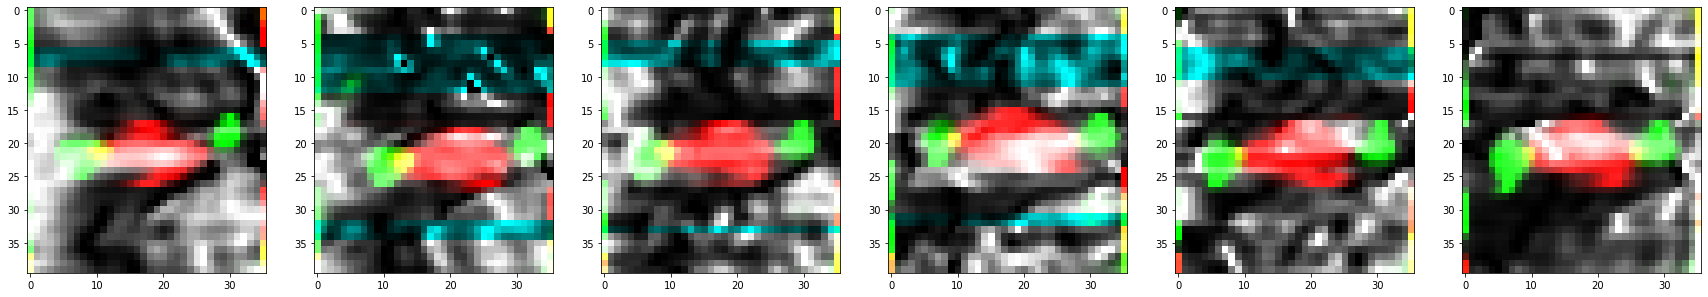

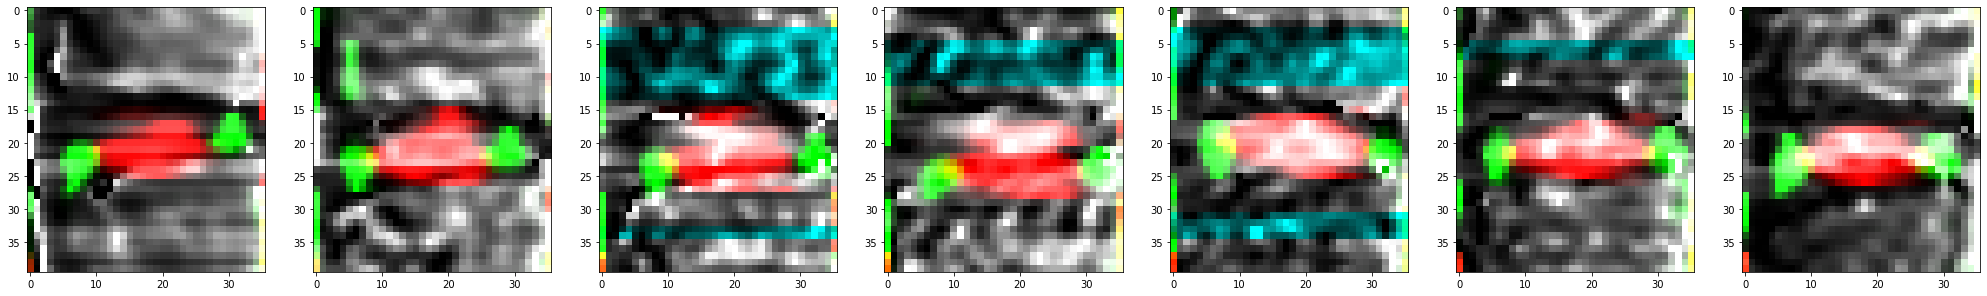

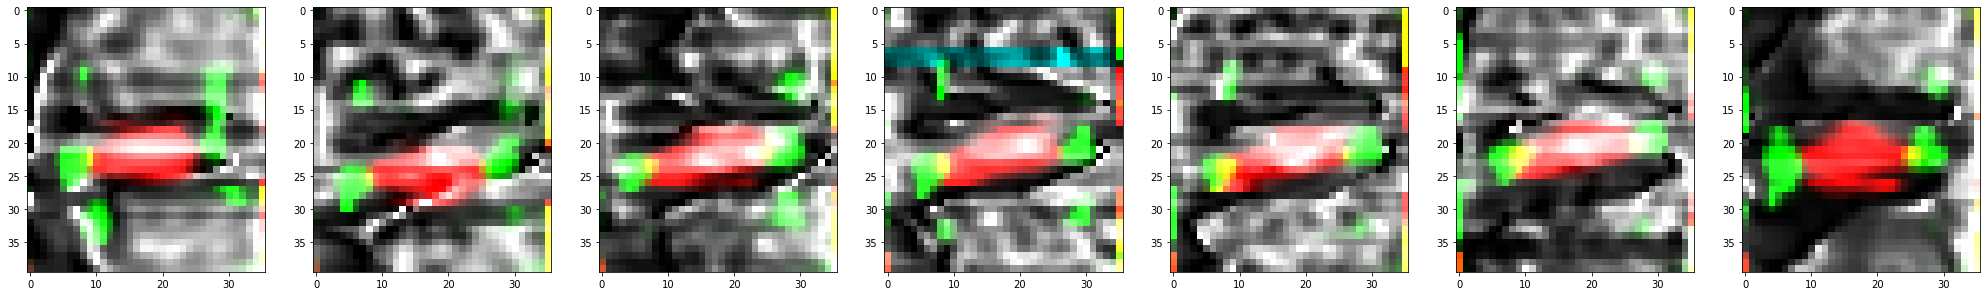

In [245]:
# see the superposition
for rois, y1_pred, y2_pred in zip(rois_ens_T1, Y1_pred_T1, Y2_pred_T1):
    plt.figure(figsize= (5*rois.shape[0],5))
    for i,(roi, y1_p, y2_p) in enumerate(zip(rois, y1_pred, y2_pred)):
        #print(y1_pred.mean(),y1_pred.max(), y1_pred.min())
        #print(roi.mean(), roi.max(), roi.min())
        roi_copy = gray2rgb(normalize(roi))
        roi_copy[:,:,0] += normalize(y1_p)
        roi_copy[:,:,1] += normalize(y2_p)
        
        plt.subplot(1, rois.shape[0], i+1)
        plt.imshow(roi_copy.squeeze())

In [246]:
def ims_size_match(ims, tgt_size):
    '''resize, 对每一个im单独resize(for 循环)， 因为ims里面的im 的size可能本来就不一样, resize之后强行转换为float格式(int16->float64)'''
    new_ims = []
    for im in ims:
        im = resize(im, tgt_size)
        new_ims.append(im)
    return np.array(new_ims)

In [247]:
# recalage semi-automatique et recherche de valeur
root_path = 'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_brut'
ims_T1sag, ims_T1, ims_T2sag, ims_T2, ims_T2star, pos, axis_ens_T1, axis_ens_T2, axis_ens_T2star = read_data(root_path, if_normalized=True)
_, ims_T1, _, ims_T2, ims_T2star, _, _, _, _ = read_data(root_path, if_normalized=False) # 读取没有normalization的数据

inds = [58, 63, 68]
names = []
for i in inds:
    p = pos[i]
    name = p[p.find('Brebis'):p.find('Brebis')+21]
    names.append(name)
names

test_T1 = ims_T1[inds]
test_T2 = ims_T2[inds]
test_T2star = ims_T2star[inds]
test_axis_ens_T1 = axis_ens_T1
test_axis_ens_T2 = axis_ens_T2
test_axis_ens_T2star = axis_ens_T2star

In [248]:
segmentation_model = Semi_auto_registration(Y1_pred, Y2_pred, rois_axis_ens, input_size, test_T1, 
                                            test_T2, test_T2star, test_axis_ens_T1, test_axis_ens_T2, test_axis_ens_T2star)
rois_ens_T1, Y1_pred_T1, Y2_pred_T1 = segmentation_model.get_rois('T1')
data_pred1 = segmentation_model.get_values(rois_ens_T1, Y1_pred_T1, Y2_pred_T1, th=0.3)
data_pred1.to_csv(r'C:\Users\chenq\Desktop\T1.csv') # 保存为csv
print(data_pred1)

                    path  valeur moyenne (centre)  valeur max (centre)  \
0  Brebis 7 (40560)\J-7\               559.489075               1265.0   
1  Brebis 8 (40141)\J-7\               519.524109               1052.0   
2  Brebis 9 (40295)\J-7\               565.602234               1093.0   

   valeur min (centre)  valeur moyenne (cote)  valeur max (cote)  \
0                 75.0             476.364594             1174.0   
1                  1.0             368.704651             2167.0   
2                  1.0             403.316711             1244.0   

   valeur min (cote)  
0               34.0  
1                1.0  
2                1.0  


In [249]:
rois_ens_T2, y1_pred_T2, y2_pred_T2 = segmentation_model.get_rois('T2')
data_pred2 = segmentation_model.get_values(rois_ens_T2, y1_pred_T2, y2_pred_T2, th=0.3)
data_pred2.to_csv(r'C:\Users\chenq\Desktop\T2.csv') # 保存为csv
print(data_pred2)

                    path  valeur moyenne (centre)  valeur max (centre)  \
0  Brebis 7 (40560)\J-7\                77.774757                332.0   
1  Brebis 8 (40141)\J-7\                54.647697                507.0   
2  Brebis 9 (40295)\J-7\                63.075989                353.0   

   valeur min (centre)  valeur moyenne (cote)  valeur max (cote)  \
0                  9.0              47.076385              640.0   
1                 11.0              40.249920              130.0   
2                  1.0              42.050171              381.0   

   valeur min (cote)  
0                9.0  
1                9.0  
2                1.0  


Brebis 7 (40560)\J-7\


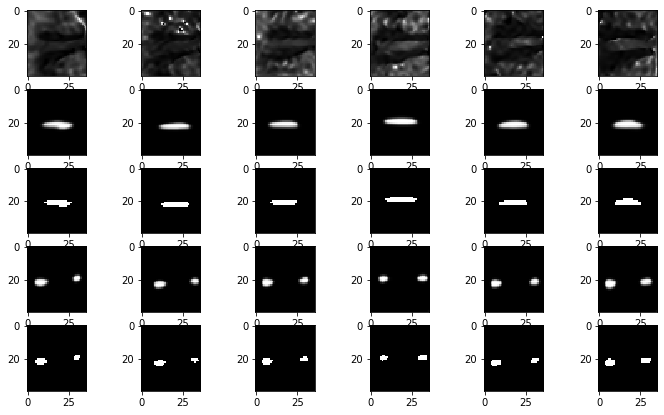

Brebis 8 (40141)\J-7\


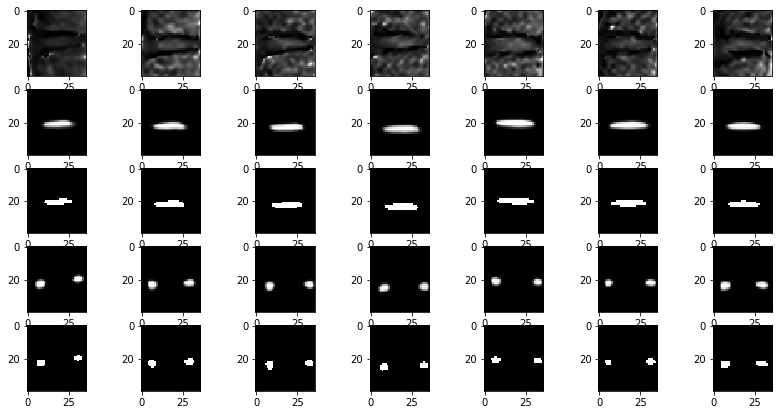

Brebis 9 (40295)\J-7\


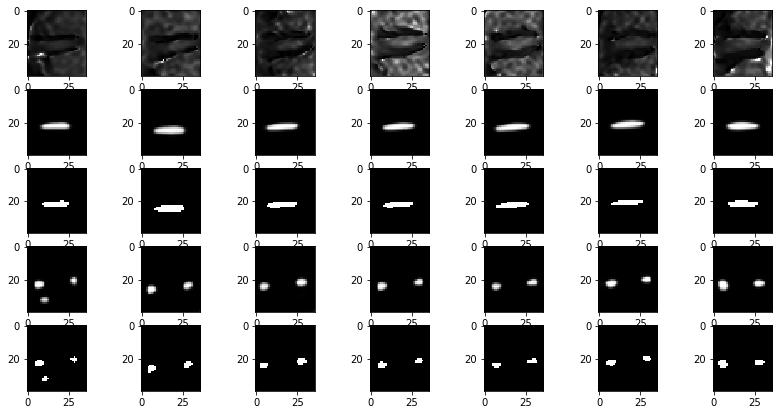

In [250]:
segmentation_model.draw_figures(rois_ens_T1, Y1_pred_T1, Y2_pred_T1, th=0.3)